In [22]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa.display
import glob
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram


In [23]:
AUDIO_FILE = 'Train\Sound/116-288045-0000.flac'
samples, sample_rate = librosa.load(AUDIO_FILE, sr=None)

AttributeError: module 'librosa.display' has no attribute 'waveplot'

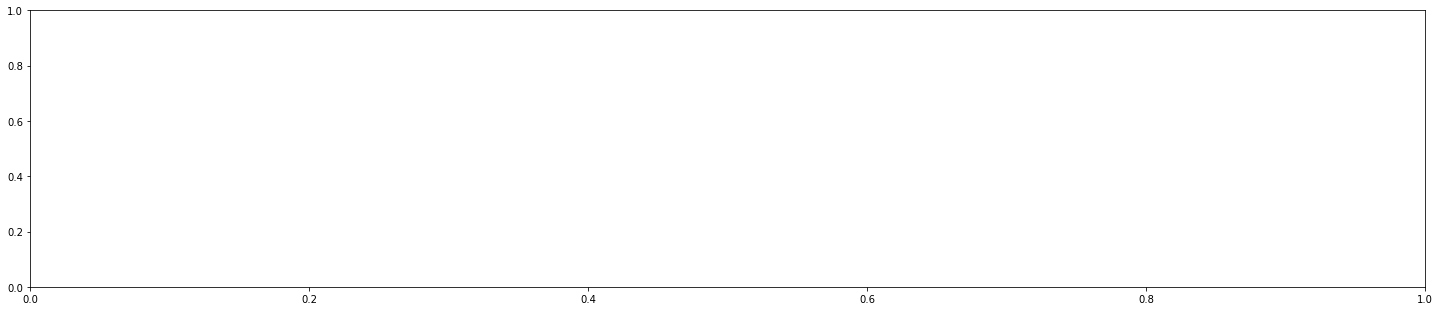

In [26]:

def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    #fig = plt.figure(figsize=(25,60), dpi = 900)
    fig = plt.figure(figsize=(25,60))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 1: Waveplot",x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_specgram(sound_names,raw_sounds):
    i = 1
    #fig = plt.figure(figsize=(25,60), dpi = 900)
    fig = plt.figure(figsize=(25,60))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 2: Spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    #fig = plt.figure(figsize=(25,60), dpi = 900)
    fig = plt.figure(figsize=(25,60))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        #D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        D = librosa.core.amplitude_to_db(np.abs(librosa.stft(f))**2, ref=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 3: Log power spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()


sound_file_paths = ["Train\Sound/116-288045-0000.flac"]

sound_names = ["air conditioner","car horn","children playing",
"dog bark","drilling","engine idling", "gun shot",
"jackhammer","siren","street music"]

raw_sounds = load_sound_files(sound_file_paths)

plot_waves(sound_names,raw_sounds)
plot_specgram(sound_names,raw_sounds)
plot_log_power_specgram(sound_names,raw_sounds)